## This is the basic load and clean stuff

In [1]:
# %load ~/dataviz/ExplorePy/clean-divvy-explore.py
import pandas as pd
import numpy as np
import datetime as datetime
import pandas.api.types as pt

from pathlib import Path


rev = "3"

input_dir = '/mnt/d/DivvyDatasets'
input_divvy_basename = "divvy_trip_history_201909-202108"
input_divvy_base = input_dir + "/" + input_divvy_basename
input_divvy_raw = input_divvy_base + ".csv"
input_divvy_rev = input_dir + "/rev" + rev + "-" + input_divvy_basename + ".csv"
input_chitemp = input_dir + "/" + "ChicagoTemperature.csv"


#
#  returns true if the rev file is already present
#
def rev_file_exists():
  path = Path(input_divvy_rev)
  return path.is_file()




def update_dow_to_category(df):
  #
  # we need to get the dow properly set
  #
  cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

  cats_type = pt.CategoricalDtype(categories=cats, ordered=True)
  df['day_of_week'] = df['day_of_week'].astype(cats_type)

  return df



#
# loads and returns the rev file as a data frame. It handles
#   the need to specify some column types
#
#  filename : the filename to load
#
def load_divvy_dataframe(filename):
  print("Loading " + filename)
  # so need to set the type on a couple of columns
  col_names = pd.read_csv(filename, nrows=0).columns
  types_dict = { 'ride_id': str, 
    'start_station_id': str,
    'end_station_id': str,
    'avg_temperature_celsius': float,
    'avg_temperature_fahrenheit': float,
    'duration': float,
    'start_lat': float,
    'start_lng': float,
    'end_lat': float,
    'end_lng': float,
    'avg_rain_intensity_mm/hour': float,
    'avg_wind_speed': float,
    'max_wind_speed': float,
    'total_solar_radiation': int
    }
  types_dict.update({col: str for col in col_names if col not in types_dict})

  return pd.read_csv(filename, dtype=types_dict)



def yrmo(year, month):
    return "{}-{}".format(year, month)




def calc_duration_in_minutes(started_at, ended_at):
    st = datetime.datetime.strptime(started_at, '%Y-%m-%d %H:%M:%S')
    en = datetime.datetime.strptime(ended_at, '%Y-%m-%d %H:%M:%S')
    diff = en - st
    return diff.total_seconds() / 60




#
# load the chicago temperature into a data frame
#
def load_temperature_dataframe():
  print("Loading " + input_chitemp)
  return pd.read_csv(input_chitemp)




#
# handles loading and processing the divvy raw data by
#   adding columns, removing bad data, etc.
#
def process_raw_divvy(filename):
  df_divvy = load_divvy_dataframe(filename)

  df_chitemp = load_temperature_dataframe()

  #
  # add a year-month column to the divvy dataframe
  #  this uses a function with the row; it is not
  #  the absolute fastest way
  #
  print("Adding year-month as yrmo")
  df_divvy['yrmo'] = df_divvy.apply(lambda row: yrmo(row['year'], row['month']),
                                      axis = 1)

  #
  # we also want a duration to be calculated
  #
  print("Adding duration")
  df_divvy['duration'] = df_divvy.apply(lambda row: calc_duration_in_minutes(row['started_at'],
                                                      row['ended_at']),
                                      axis = 1)

  #
  # add the temperature
  #
  print("Merging in temperature")
  df_divvy = pd.merge(df_divvy, df_chitemp,
    on="date")
  print(df_divvy.shape)
  print(df_divvy.head())
  # print(df_divvy.loc[df_divvy['date'] == '2020-02-21']) # 2020-02-21 was missing in org. temp

  print(df_divvy.info())  # shows mem usage, other info
  print(df_divvy[['ride_id','member_casual','date','duration','yrmo','avg_temperature_fahrenheit']])

  #
  # clean the dataframe to remove invalid durations
  #   which are really only (about) < 1 minute, or > 12 hours
  #
  print("Removing invalid durations")
  df_divvy = df_divvy[(df_divvy.duration >= 1.2) & (df_divvy.duration < 60 * 12)]
  print(df_divvy.shape)

  df_divvy = update_dow_to_category(df_divvy)

  #
  # drop some bogus columns
  #
  df_divvy.drop(df_divvy.columns[[0,30]], axis=1, inplace=True)

  return df_divvy




#
# writes the dataframe to the specified filename
#
def save_dataframe(df, filename):
  print("Saving dataframe to " + filename)
  df.to_csv(filename, index=False)


#
# load the divvy csv into a data frame
#
if rev_file_exists():
  df_divvy = load_divvy_dataframe(input_divvy_rev)
  df_divvy = update_dow_to_category(df_divvy)
else:
  df_divvy = process_raw_divvy(input_divvy_raw)
  save_dataframe(df_divvy, input_divvy_rev)

print(df_divvy)
df_divvy.info()






#
# btw, can just pass the row and let the function figure it out
#
#def procone(row):
#    print(row['date'])
#    return 0
#df_divvy.apply(lambda row: procone(row), axis = 1)







Loading /mnt/d/DivvyDatasets/rev3-divvy_trip_history_201909-202108.csv
              ID     ...1           ride_id rideable_type  \
0        1147482  8267501          24710636   docked_bike   
1        1147483  8267502          24710637   docked_bike   
2        1147484  8267503          24710638   docked_bike   
3        1147485  8267504          24710639   docked_bike   
4        1147486  8267505          24710640   docked_bike   
...          ...      ...               ...           ...   
8190302  9464757  6162300  98EAC61BBAAF73C9  classic_bike   
8190303  9464758  6162336  B060D2DF6AC0D65B  classic_bike   
8190304  9464759  6162481  D22E7B3E5C0D162E  classic_bike   
8190305  9464760  6162496  4C86FE37842CD185  classic_bike   
8190306  9464761  6162497  6BEE9ACBA8E9BD51  classic_bike   

                  started_at             ended_at  \
0        2019-09-01 00:00:15  2019-09-01 00:05:00   
1        2019-09-01 00:00:48  2019-09-01 00:06:46   
2        2019-09-01 00:01:13  2019-09

## Look at the average duration by rider type & day of week
### average duration by day of week for rider types

In [2]:
type(df_divvy['duration'])

pandas.core.series.Series

In [3]:
df_divvy.info()
df_divvy.shape

df_rider_by_dow = df_divvy.groupby(['member_casual','day_of_week']).agg(mean_time = ('duration', 'mean')).round(2)
df_rider_by_dow

df_rider_by_dow.sort_values(by=['member_casual','day_of_week'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190307 entries, 0 to 8190306
Data columns (total 29 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   ID                          object  
 1   ...1                        object  
 2   ride_id                     object  
 3   rideable_type               object  
 4   started_at                  object  
 5   ended_at                    object  
 6   start_station_name          object  
 7   start_station_id            object  
 8   end_station_name            object  
 9   end_station_id              object  
 10  start_lat                   float64 
 11  start_lng                   float64 
 12  end_lat                     float64 
 13  end_lng                     float64 
 14  member_casual               object  
 15  date                        object  
 16  month                       object  
 17  day                         object  
 18  year                        object  
 19  

mean_time
member_casual day_of_week           
casual        Monday           31.34
              Tuesday          28.65
              Wednesday        28.07
              Thursday         27.94
              Friday           29.24
              Saturday         33.72
              Sunday           35.30
member        Monday           13.46
              Tuesday          13.32
              Wednesday        13.40
              Thursday         13.38
              Friday           13.73
              Saturday         15.98
              Sunday           16.14

### Now we want to plot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

#### bar plot of Duration by Rider Type and Day of Week

<AxesSubplot:xlabel='day_of_week'>

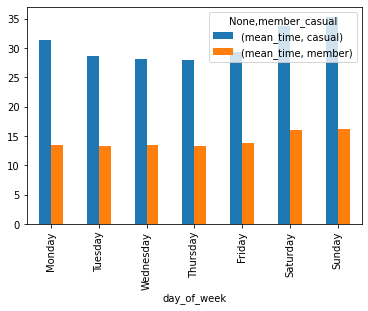

In [5]:
df_rider_by_dow.unstack('member_casual').plot(kind='bar')

<AxesSubplot:xlabel='day_of_week', ylabel='mean_time'>

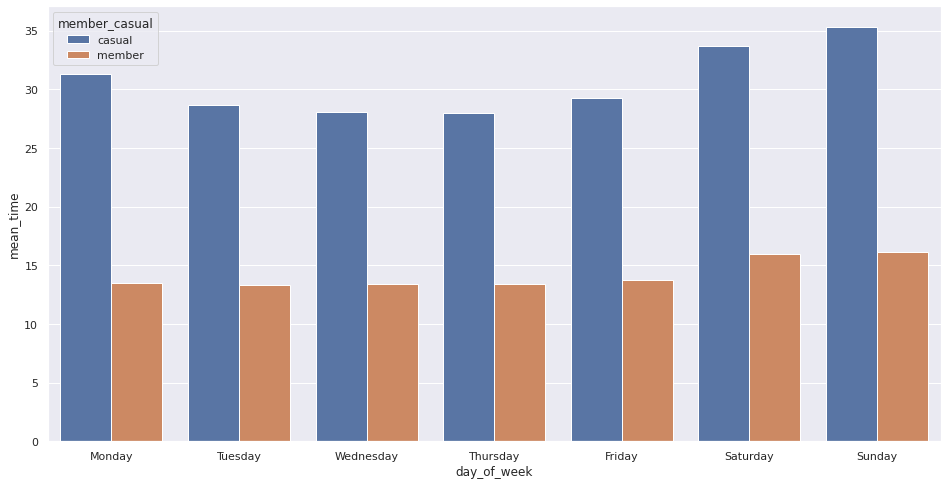

In [6]:
df_rider_by_dow.reset_index(inplace=True)
sns.set(rc={"figure.figsize":(16,8)})
sns.barplot(data=df_rider_by_dow, x="day_of_week", y="mean_time", hue="member_casual")

## Look at the number of riders by type and day of week
### grouping

In [7]:
df_rider_by_dow = df_divvy.groupby(['member_casual','day_of_week']).agg(num_rides = ('ID', 'count'))
df_rider_by_dow

#df_rider_by_dow['day_of_week'] = df_rider_by_dow['day_of_week'].astype(cats_type)
df_rider_by_dow.sort_values(by=['member_casual','day_of_week'])

num_rides
member_casual day_of_week           
casual        Monday          368155
              Tuesday         347995
              Wednesday       350736
              Thursday        371177
              Friday          467382
              Saturday        734235
              Sunday          628519
member        Monday          706423
              Tuesday         753748
              Wednesday       749612
              Thursday        742154
              Friday          727633
              Saturday        658274
              Sunday          584264

### plot of Number of Rids by Rider Type and Day of Week

<AxesSubplot:xlabel='day_of_week'>

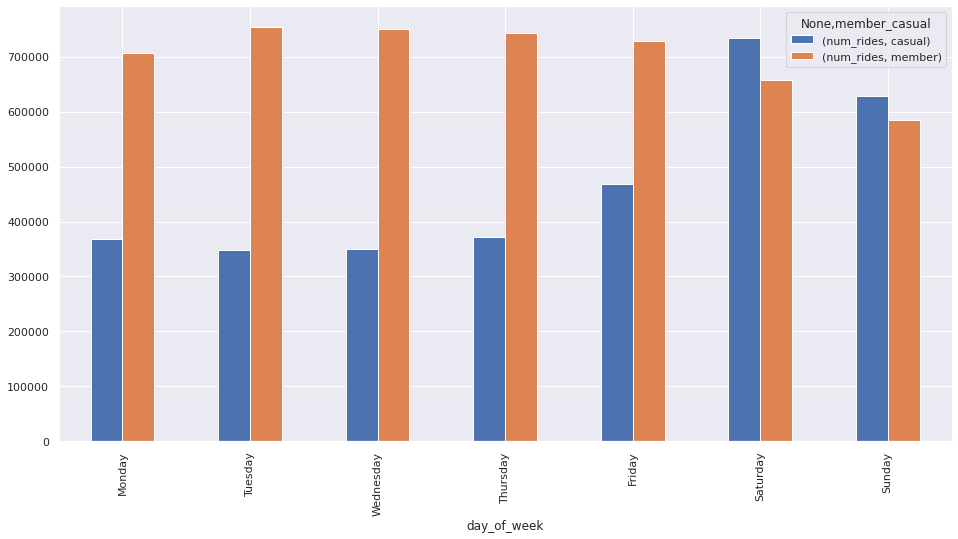

In [8]:
df_rider_by_dow.unstack('member_casual').plot(kind='bar')

<AxesSubplot:xlabel='day_of_week', ylabel='num_rides'>

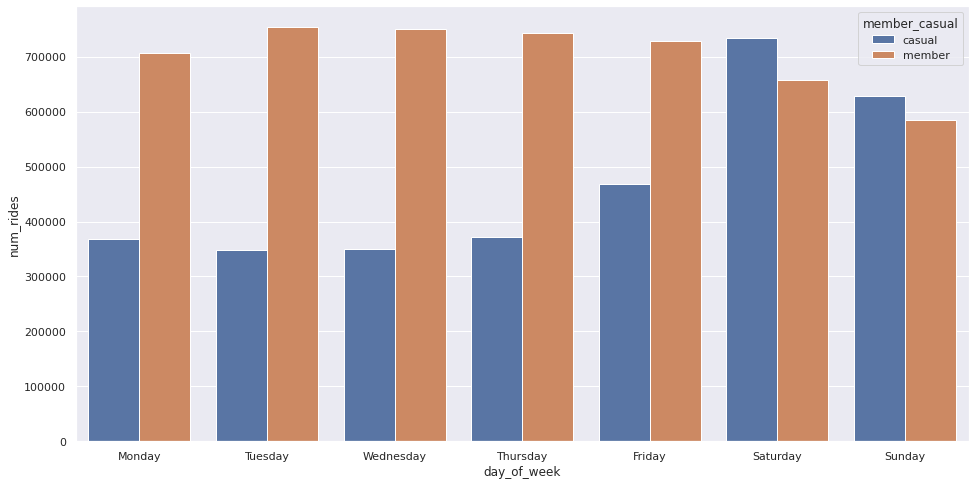

In [9]:
df_rider_by_dow.reset_index(inplace=True)
sns.set(rc={"figure.figsize":(16,8)})
sns.barplot(data=df_rider_by_dow, x="day_of_week", y="num_rides", hue="member_casual")